### Imports

In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import peakutils
import os, glob
import data_tools as dt

### Directories

In [3]:
data_dir = os.path.join('./raw_data')
analysis_dir = os.path.join('./analysis')
fig_dir = os.path.join('./figures')

### Constants

In [4]:
MU_B = 5.7883818012e-5 # eV/T
K_B = 8.6173303e-5 # eV/K

# CB peak 1

### closed dot

Drain side of the dot is closed, calculate lever arm by fitting sensor transition width vs mixing chamber temperature.

In [5]:
# in this data set...
#    temperature controlled the fridge 
#    then ran a repeated scan of the plunger to get the peak width

# dataset information
dats = list(range(638,652))
n = len(dats)
m = 10 # number of repeated sweeps in 2D data
xmult = [0.5, 1.0] # gate voltage divider, index

# setup fits
xlim = (-485, -465)
span = 5.0
avgs = 5

df = pd.DataFrame(columns=['x0', 'beta', 'i0', 'i1', 'i2']) # data frame to hold fit params
for i, dat in enumerate(dats):

    swp = dt.open_hdf5(dat, path=data_dir) # load sweep data
    _temp = swp['mc2d'][:].mean(axis=1) # avg temperature for each row
    
    x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['i_sense2d'][:], 
                            avgs, axis=1) # rolling mean of sensor data
    
    # find avg center position for fits
    dz = dt.dfdx(z, x, axis = 1)
    argmins = np.argmin(dz, axis=1)
    centers = x[argmins].mean()*np.ones(len(z))

    # fit all curves
    results = dt.i_sense_fit_simultaneous(x, z*1e9, centers, _temp/275, 
                                            xlim, constrain = None, span = span) 
    results['Tmc'] = _temp
    df = pd.concat([df, results], ignore_index=True)    

df.to_csv(os.path.join(analysis_dir,'lever-arm_peak1_dataset_1.csv'), index=False) # save

In [6]:
# in this data set...
#    warm up/cool down while continuously sweeping the plunger 

# dataset information
dat = 719
n = 217
xmult = [0.5, 1.0] # gate voltage divider, index

# setup fits 
xlim = (-490, -475)
span=5.0
avgs = 5

swp = dt.open_hdf5(dat, path=data_dir) # load sweep
temps = swp['mc2d'][0:n].mean(axis=1) # avg temp of each row
x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['i_sense2d'][0:n], 
                        avgs, axis=1) # rolling mean of sensor data

# estimate centers for fits
dz = dt.dfdx(z, x, axis = 1)
argmins = np.argmin(dz, axis=1)
realmins = x[argmins]
y = swp['y_array'][0:n]*xmult[1]
popt = np.polyfit(y, realmins, deg=1)
centers = dt.line(y, *popt)

widths = 0.8*np.ones(len(z)) # guess at peak widths

# fit all curves
df = dt.i_sense_fit_simultaneous(x, z*1e9, centers, widths, 
                                  xlim, constrain = None, span = span)
df['Tmc'] = temps

df.to_csv(os.path.join(analysis_dir,'lever-arm_peak1_dataset_2.csv'), index=False)

In [7]:
# in this data set...
#    fix mixing chamber heater value, waited for stable temp 
#    then ran a repeated scan of the plunger to get the peak width

# dataset information
dats = list(range(741,755))
n = len(dats)
m = 5 # number of repeated sweeps in one wave
xmult = [0.5, 1.0]

# setup fits
xlim = (-495, -475)
span = 5.0
avgs = 5

df = pd.DataFrame(columns=['x0', 'beta', 'i0', 'i1', 'i2']) # data frame to hold fit params
for i, dat in enumerate(dats):

    swp = dt.open_hdf5(dat, path=data_dir) # load sweep data
    _temp = swp['mc2d'][:].mean(axis=1) # avg temperature for each row
    
    x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['i_sense2d'][:], 
                            avgs, axis=1) # rolling mean of sensor data
    
    # find avg center position for fits
    y = swp['y_array'][:]*xmult[1]
    dz = dt.dfdx(z, x, axis = 1)
    argmins = np.argmin(dz, axis=1)
    centers = x[argmins].mean()*np.ones(len(z))
    widths = 0.8*np.ones(len(z))

    # fit all curves
    results = dt.i_sense_fit_simultaneous(x, z*1e9, centers, widths, 
                                            xlim, constrain = None, span = span) 
    results['Tmc'] = _temp
    df = pd.concat([df, results], ignore_index=True)    

df.to_csv(os.path.join(analysis_dir,'lever-arm_peak1_dataset_3.csv'), index=False) # save

<IPython.core.display.Javascript object>


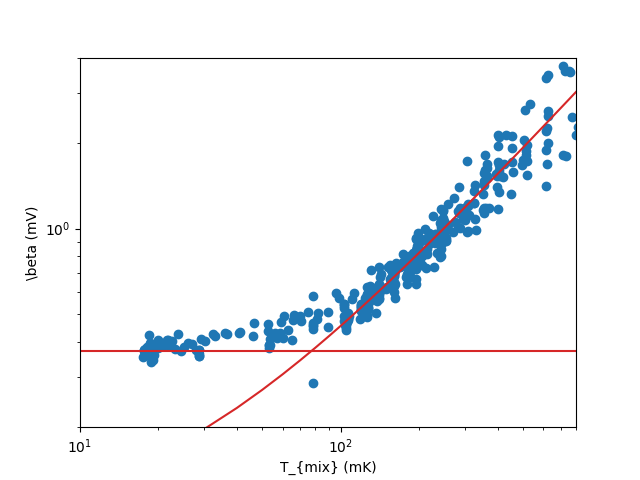

T(mK)=0.003677*width(mV) + 0.0868
alpha_{01}=0.0469


In [8]:
# plot all CB peak 1 temp results

fig, ax = plt.subplots(1,1)

# load data to big giant dataframe
datafiles = ['lever-arm_peak1_dataset_{0:d}.csv'.format(i+1) for i in range(3)]
df = pd.concat((pd.read_csv(os.path.join(analysis_dir,f)) for f in datafiles), 
                   ignore_index=True)
df.sort_values(by='Tmc', ascending=True, inplace=True)

# plot original data
ax.scatter(df['Tmc'], df['beta'], c='C0')
ax.axhline(y=df['beta'].iloc[0:5].mean(), c='C3')

ff = df.loc[(df['Tmc'] > 100.0) & (df['Tmc'] < 500.0)]
popt = np.polyfit(ff['Tmc'], ff['beta'], deg=1)
tnew = np.linspace(10,800,80)
ax.plot(tnew, dt.line(tnew, *popt), c='C3')

ax.set_xlim(10, 800)
ax.set_ylim(0.2, 4.0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'\beta (mV)')
ax.set_xlabel(r'T_{mix} (mK)')

print(r'T(mK)={0:.4g}*width(mV) + {1:.3g}'.format(*popt))
print(r'alpha_{{01}}={0:.4f}'.format(2*K_B/popt[0]))

### open dot

Calculate lever arm and excited state energy from Coulomb diamond.

<IPython.core.display.Javascript object>


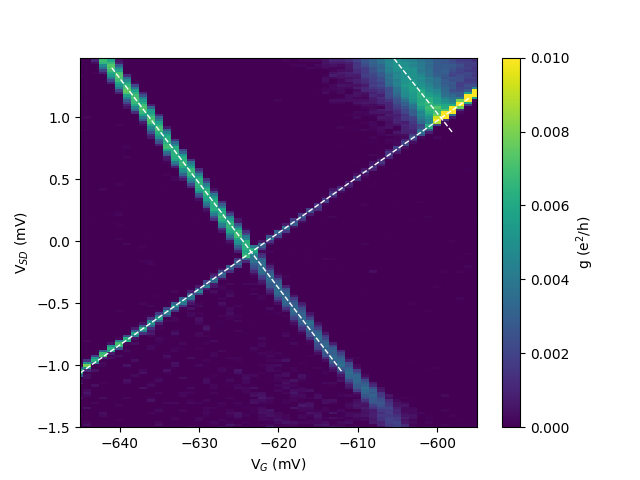

alpha_{01} = 0.02945 meV/mV
V_{bias} offset = -88.0 uV
dE = 992.7 ueV


In [9]:
dat = 1228
xmult = [0.01, 0.5] # bias mV, gate 10 mV

fig, ax = plt.subplots(1,1)

swp = dt.open_hdf5(dat, path=data_dir) # load sweep
gate = swp['y_array'][:]*xmult[1]
bias = swp['x_array'][:]*xmult[0]
cond = swp['g_dot2d'][:].transpose()
x, y, z = dt.get_subset((gate, bias, cond), [-645,-594,-1.5,1.5])

xx, yy = dt.xy_to_meshgrid(x, y)
cax = ax.pcolormesh(xx, yy, z, vmin=0, vmax=0.01)
cb = fig.colorbar(cax)
cb.set_label('g (e$^2$/h)')

ax.set_xlabel('V$_{G}$ (mV)')
ax.set_ylabel('V$_{SD}$ (mV)')
ax.set_xlim(x[0],x[-1])
ax.set_ylim(y[0],y[-1])

xypeaks = []
for i in range(len(z)):
    ipeak = peakutils.indexes(z[i], thres=0.75)
    for j in ipeak:
        xypeaks.append([x[j], y[i]])
xypeaks = np.array(xypeaks)

# plot guess at GS drain line
gate = np.linspace(-645,-596, 10000)
bias = dt.line(gate, 0.045,27.95)
# check if points are on line
mask = [dt.dist_2_line(gate, bias, p, 0.05) for p in xypeaks]
drain_gs = np.polyfit(xypeaks[mask,0], xypeaks[mask,1], deg=1)
ax.plot(gate, dt.line(gate, *drain_gs), c='w', lw=1, ls='--')

# plot guess at GS source line
gate = np.linspace(-641,-612, 10000)
bias = dt.line(gate, -0.083,-51.82)
# check if points are on line
mask = [dt.dist_2_line(gate, bias, p, 0.09) for p in xypeaks]
source_gs = np.polyfit(xypeaks[mask,0], xypeaks[mask,1], deg=1)
ax.plot(gate, dt.line(gate, *source_gs), c='w', lw=1, ls='--')

# plot guess at ES source line
gate = np.linspace(-606,-598, 10000)
bias = dt.line(gate, -0.083,-48.76)
# check if points are on line
mask = [dt.dist_2_line(gate, bias, p, 0.06) for p in xypeaks]
source_es = np.polyfit(xypeaks[mask,0], xypeaks[mask,1], deg=1)
ax.plot(gate, dt.line(gate, *source_es), c='w', lw=1, ls='--')

# use these to calculate the lever arm for gate 10
alpha = 1/np.abs(1/drain_gs[0]-1/source_gs[0])
voffset = 1000*dt.y_intersection(source_gs, drain_gs)
es = 1000*dt.y_intersection(source_es, drain_gs)

print('alpha_{{01}} = {0:.4g} meV/mV'.format(alpha))
print('V_{{bias}} offset = {0:.1f} uV'.format(voffset))
print('dE = {0:.1f} ueV'.format(es))

Calculate g-factor from finite bias sweep of plunger gate vs parallel field.

<IPython.core.display.Javascript object>


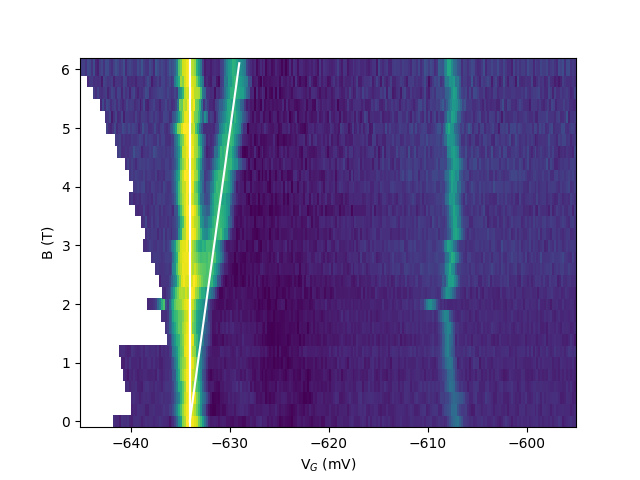

g_{1,open} = 0.417


In [10]:
dat = 1232
xmult = [0.5, 1e-3] # gate 10 in mV, field in T

fig, ax = plt.subplots(1,1)

# import dataset 
swp = dt.open_hdf5(dat, path=data_dir) # load sweep
x = swp['x_array'][:]*xmult[0]
y = swp['y_array'][:]*xmult[1]
z = swp['g_dot2d'][:]*1000

# get peak positions and
xshift = np.empty((len(z),1))
xypeaks = []
for j in range(len(z)):
    
    # find x-shift to line up gs at zero energy
    ipeak = peakutils.indexes(z[j], thres=0.9)
    xshift[j] = sum([x[p] for p in ipeak])/len(ipeak)
    
    # find all peaks with lower threshold
    ipeak = peakutils.indexes(z[j], thres=0.65)
    for p in ipeak:
        xypeaks.append([(x[p]-xshift[j]), y[j]])
        
xypeaks = np.array(xypeaks) # create numpy array

# create arrays for plotting
dx = (x[-1] - x[0]) / float(len(x) - 1)
dy = (y[-1] - y[0]) / float(len(y) - 1)
xplt = np.append(x-dx/2.0,x[-1]+dx)
yplt = np.append(y-dy/2.0,y[-1]+dy)

# create color plot line by line
for i in range(len(z)):
    xtmp = (xplt - xshift[i])+xshift.mean()
    ytmp = yplt[i], yplt[i+1]
    xx, yy = np.meshgrid(xtmp, ytmp) # create grid + flip axes
    ax.pcolormesh(xx, yy, z[i,None])

def g_line(x, a): 
    return a*x
mask = xypeaks[:,0]>1.0 # fit only excited state peaks
a, _, _, _ = np.linalg.lstsq(xypeaks[mask,0,None], xypeaks[mask,1])
ax.axvline(x=xshift.mean(), c='2')
ax.plot(np.linspace(0,5,200)+xshift.mean(), a*np.linspace(0,5,200), c='w')
ax.set_ylabel('B (T)')
ax.set_xlabel('V$_{G}$ (mV)')
ax.set_xlim(None, -595);

# calculate g factor from slope
print('g_{{1,open}} = {0:.3f}'.format(0.001*0.02945/a[0]/MU_B))

# save arrays to recreate plot...
np.savetxt(os.path.join(analysis_dir, "dat1232_xshift.csv"), xshift, delimiter=",")
np.savetxt(os.path.join(analysis_dir, "dat1232_xplt.csv"), xplt, delimiter=",")
np.savetxt(os.path.join(analysis_dir, "dat1232_yplt.csv"), yplt, delimiter=",")

# CB peak 2

### closed dot

Drain side of the dot is closed, calculate lever arm by fitting sensor transition width vs mixing chamber temperature.

In [11]:
# in this data set...
#    temperature controlled the fridge 
#    then ran a repeated scan of the plunger to get the peak width

# dataset information
dats = list(range(686,698))
n = len(dats)
m = 10 # number of repeated sweeps in 2D data
xmult = [0.5, 1.0] # gate voltage divider, index

# setup fits
xlim = (-460, -440)
span = 5.0
avgs = 5

df = pd.DataFrame(columns=['x0', 'beta', 'i0', 'i1', 'i2']) # data frame to hold fit params
for i, dat in enumerate(dats):

    swp = dt.open_hdf5(dat, path=data_dir) # load sweep data
    _temp = swp['mc2d'][:].mean(axis=1) # avg temperature for each row
    
    x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['i_sense2d'][:], 
                            avgs, axis=1) # rolling mean of sensor data
    
    # find avg center position for fits
    dz = dt.dfdx(z, x, axis = 1)
    argmins = np.argmin(dz, axis=1)
    centers = x[argmins].mean()*np.ones(len(z))

    # fit all curves
    results = dt.i_sense_fit_simultaneous(x, z*1e9, centers, _temp/275, 
                                            xlim, constrain = None, span = span) 
    results['Tmc'] = _temp
    df = pd.concat([df, results], ignore_index=True)    

df.to_csv(os.path.join(analysis_dir,'lever-arm_peak2_dataset_1.csv'), index=False) # save

In [12]:
# in this data set...
#    warm up/cool down while continuously sweeping the plunger 

# dataset information
dat = 700
n = 96
xmult = [0.5, 1.0] # gate voltage divider, index

# setup fits 
xlim = (-470, -440)
span=5.0
avgs = 5

swp = dt.open_hdf5(dat, path=data_dir) # load sweep
temps = swp['mc2d'][0:n].mean(axis=1) # avg temp of each row
x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['i_sense2d'][0:n], 
                        avgs, axis=1) # rolling mean of sensor data

# estimate centers for fits
dz = dt.dfdx(z, x, axis = 1)
argmins = np.argmin(dz, axis=1)
realmins = x[argmins]
y = swp['y_array'][0:n]*xmult[1]
popt = np.polyfit(y, realmins, deg=1)
centers = dt.line(y, *popt)

widths = 0.8*np.ones(len(z)) # guess at peak widths

# fit all curves
df = dt.i_sense_fit_simultaneous(x, z*1e9, centers, widths, 
                                  xlim, constrain = None, span = span)
df['Tmc'] = temps

df.to_csv(os.path.join(analysis_dir,'lever-arm_peak2_dataset_2.csv'), index=False)

In [13]:
# in this data set...
#    fix mixing chamber heater value, waited for stable temp 
#    then ran a repeated scan of the plunger to get the peak width

# dataset information
dats = list(range(701,715))
n = len(dats)
m = 5 # number of repeated sweeps in one wave
xmult = [0.5, 1.0]

# setup fits
xlim = (-460, -445)
span = 5.0
avgs = 5

df = pd.DataFrame(columns=['x0', 'beta', 'i0', 'i1', 'i2']) # data frame to hold fit params
for i, dat in enumerate(dats):

    swp = dt.open_hdf5(dat, path=data_dir) # load sweep data
    _temp = swp['mc2d'][:].mean(axis=1) # avg temperature for each row
    
    x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['i_sense2d'][:], 
                            avgs, axis=1) # rolling mean of sensor data
    
    # find avg center position for fits
    y = swp['y_array'][:]*xmult[1]
    dz = dt.dfdx(z, x, axis = 1)
    argmins = np.argmin(dz, axis=1)
    centers = x[argmins].mean()*np.ones(len(z))
    widths = 0.8*np.ones(len(z))

    # fit all curves
    results = dt.i_sense_fit_simultaneous(x, z*1e9, centers, widths, 
                                            xlim, constrain = None, span = span) 
    results['Tmc'] = _temp
    df = pd.concat([df, results], ignore_index=True)    

df.to_csv(os.path.join(analysis_dir,'lever-arm_peak2_dataset_3.csv'), index=False) # save

<IPython.core.display.Javascript object>


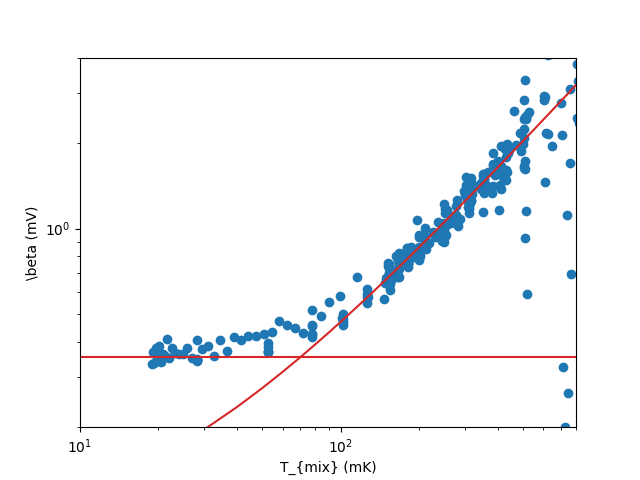

T(mK)=0.003903*width(mV) + 0.0793
alpha_{12}=0.0442


In [14]:
# plot all CB peak 2 temp results

fig, ax = plt.subplots(1,1)

# load data to big giant dataframe
datafiles = ['lever-arm_peak2_dataset_{0:d}.csv'.format(i+1) for i in range(3)]
df = pd.concat((pd.read_csv(os.path.join(analysis_dir,f)) for f in datafiles), 
                   ignore_index=True)
df.sort_values(by='Tmc', ascending=True, inplace=True)

# plot original data
ax.scatter(df['Tmc'], df['beta'], c='C0')
ax.axhline(y=df['beta'].iloc[0:5].mean(), c='C3')

ff = df.loc[(df['Tmc'] > 100.0) & (df['Tmc'] < 500.0)]
popt = np.polyfit(ff['Tmc'], ff['beta'], deg=1)
tnew = np.linspace(10,800,80)
ax.plot(tnew, dt.line(tnew, *popt), c='C3')

ax.set_xlim(10, 800)
ax.set_ylim(0.2, 4.0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'\beta (mV)')
ax.set_xlabel(r'T_{mix} (mK)')

print(r'T(mK)={0:.4g}*width(mV) + {1:.3g}'.format(*popt))
print(r'alpha_{{12}}={0:.4f}'.format(2*K_B/popt[0]))

### open dot

Calculate lever arm and singlet triplet energy from Coulomb diamond.

<IPython.core.display.Javascript object>


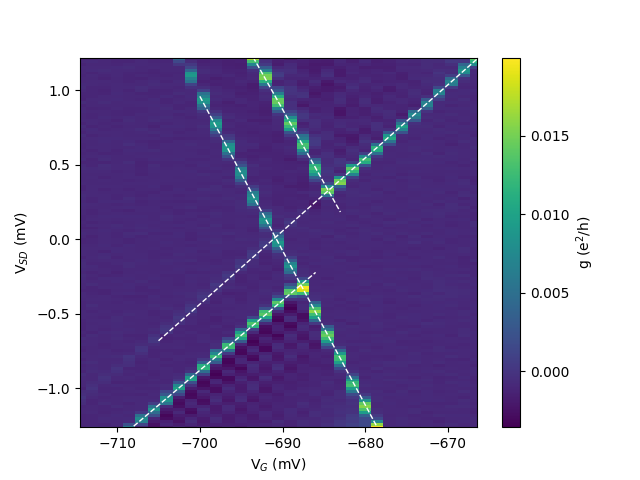

alpha_{12} = 0.03329 meV/mV
V_{bias} offset = 13.9 uV
dE_{ST} = 316.4 ueV


In [15]:
dat = 1087
xmult = [0.01, 0.5] # bias mV, gate 10 mV

fig, ax = plt.subplots(1,1)

swp = dt.open_hdf5(dat, path=data_dir) # load sweep
gate = swp['y_array'][:]*xmult[1]
bias = swp['x_array'][:]*xmult[0]
cond = swp['g_dot2d'][:].transpose()
x, y, z = dt.get_subset((gate, bias, cond), [-715,-665,-1.25,1.25])

xx, yy = dt.xy_to_meshgrid(x, y)
cax = ax.pcolormesh(xx, yy, z)
cb = fig.colorbar(cax)
cb.set_label('g (e$^2$/h)')

ax.set_xlabel('V$_{G}$ (mV)')
ax.set_ylabel('V$_{SD}$ (mV)')
ax.set_xlim(x[0],x[-1])
ax.set_ylim(y[0],y[-1])

xypeaks = []
for i in range(len(z)):
    ipeak = peakutils.indexes(z[i], thres=0.8)
    for j in ipeak:
        xypeaks.append([x[j], y[i]])
xypeaks = np.array(xypeaks)

# plot guess at ES drain line
gate = np.linspace(-708,-686, 10000)
bias = dt.line(gate, 0.048,32.7)
# check if points are on line
mask = [dt.dist_2_line(gate, bias, p, 0.05) for p in xypeaks]
drain_es = np.polyfit(xypeaks[mask,0], xypeaks[mask,1], deg=1)
ax.plot(gate, dt.line(gate, *drain_es), c='w', lw=1, ls='--')

# plot guess at GS drain line
gate = np.linspace(-705,-666, 10000)
bias = dt.line(gate, 0.0483,33.4)
# check if points are on line
mask = [dt.dist_2_line(gate, bias, p, 0.05) for p in xypeaks]
drain_gs = np.polyfit(xypeaks[mask,0], xypeaks[mask,1], deg=1)
ax.plot(gate, dt.line(gate, *drain_gs), c='w', lw=1, ls='--')

# plot guess at GS source line
gate = np.linspace(-700,-677, 10000)
bias = dt.line(gate, -0.103,-71.15)
# check if points are on line
mask = [dt.dist_2_line(gate, bias, p, 0.09) for p in xypeaks]
source_gs = np.polyfit(xypeaks[mask,0], xypeaks[mask,1], deg=1)
ax.plot(gate, dt.line(gate, *source_gs), c='w', lw=1, ls='--')

# plot guess at ES source line
gate = np.linspace(-694,-683, 10000)
bias = dt.line(gate, -0.103,-70.2)
# check if points are on line
mask = [dt.dist_2_line(gate, bias, p, 0.06) for p in xypeaks]
source_es = np.polyfit(xypeaks[mask,0], xypeaks[mask,1], deg=1)
ax.plot(gate, dt.line(gate, *source_es), c='w', lw=1, ls='--')

# use these to calculate the lever arm for gate 10
alpha = 1/np.abs(1/drain_gs[0]-1/source_gs[0])
voffset = 1000*dt.y_intersection(source_gs, drain_gs)
est = 500*(np.abs(dt.y_intersection(source_es, drain_gs))+np.abs(dt.y_intersection(source_gs, drain_es)))

print('alpha_{{12}} = {0:.4g} meV/mV'.format(alpha))
print('V_{{bias}} offset = {0:.1f} uV'.format(voffset))
print('dE_{{ST}} = {0:.1f} ueV'.format(est))

<IPython.core.display.Javascript object>


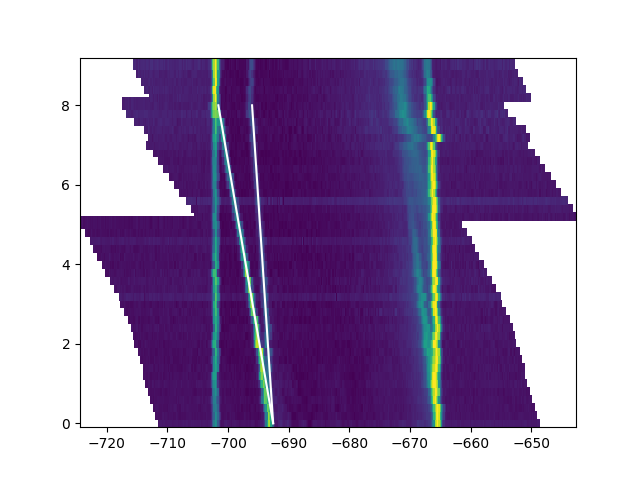

g_{2,open} = 0.400


In [21]:
fig, ax = plt.subplots(1,1)

dats = [1082, 1083, 1084]
n = [-5, None, None]
length = [26, 15, 5]
xmult = [0.5, 1e-3] # gate 10 in mV, field in T
gate_offset = -702 # chosen such that g factor and CD data line up despite gate shift

xypeaks = []
for i, dat in enumerate(dats):
    
    # import data
    swp = dt.open_hdf5(dat, path=data_dir) # load sweep
    x = swp['x_array'][:]*xmult[0]
    y = swp['y_array'][:n[i]]*xmult[1]
    z = swp['g_dot2d'][:n[i]]

    # find peaks
    xshift = np.zeros(len(z))
    for j in range(len(z)):
        ipeak = peakutils.indexes(z[j], thres=0.2)
        xshift[j] = x[ipeak[0]]
        for p in ipeak:
            xypeaks.append([x[p]-x[ipeak[0]], y[j]])
    
    # create arrays for plotting
    dx = (x[-1] - x[0]) / float(len(x) - 1)
    dy = (y[-1] - y[0]) / float(len(y) - 1)
    xplt = np.append(x-dx/2.0,x[-1]+dx)
    yplt = np.append(y-dy/2.0,y[-1]+dy)

    # create color plot line by line
    for j in range(len(z)):
        xtmp = (xplt - xshift[j])+gate_offset
        ytmp = yplt[j], yplt[j+1]
        xx, yy = np.meshgrid(xtmp, ytmp) # create grid + flip axes
        ax.pcolormesh(xx, yy, z[j,None])
    
    # save data for later
    np.savetxt(os.path.join(analysis_dir, "dat{0:d}_xshift.csv".format(dat)), xshift, delimiter=",")
    np.savetxt(os.path.join(analysis_dir, "dat{0:d}_xplt.csv".format(dat)), xplt, delimiter=",")
    np.savetxt(os.path.join(analysis_dir, "dat{0:d}_yplt.csv".format(dat)), yplt, delimiter=",")
            
xypeaks = np.array(xypeaks)

# select only T_0 and T_+ peaks
mask = (xypeaks[:,0]>0.5) & (xypeaks[:,0]<10.0)
tpeaks = xypeaks[mask,:]

txplus = []
txzero = []
ty = []
for field in np.unique(tpeaks[:,1]):
    mask = (np.abs(tpeaks[:,1] - field) < 1e-6)
    if mask.sum()==2:
        ty.append(field)
        txplus.append(tpeaks[mask][:,0][0])
        txzero.append(tpeaks[mask][:,0][1])
        
ty = np.array(ty)
txzero = np.array(txzero)
txplus = np.array(txplus)
tx = np.stack((txplus, txzero))

# fit lines through T_0 and T_+ with same x-intercept
def line_dataset(params, i, xx):

    a = params['a{0:d}'.format(i)]
    b = params['b{0:d}'.format(i)]

    return a*xx + b
    
def line_objective(params, xx, yy):

    resid = []
    # make residual per data set
    for i in range(len(yy)):
        resid.append(yy[i,:] - line_dataset(params, i, xx))
    # now flatten this to a 1D array, as minimize() needs
    return np.concatenate(resid)

fit_params = dt.Parameters()
fit_params.add('a0', value=20.0)
fit_params.add('b0', value=300.0)
fit_params.add('a1', value=20.0)
fit_params.add('b1', value=300.0)
fit_params['b1'].expr = 'b0'

m = dt.minimize(line_objective, fit_params, args=(ty, tx))
valdict = m.params.valuesdict()

fields = np.linspace(0,8, 200)
ax.plot(valdict['a0']*fields+valdict['b0']+gate_offset, fields, c='w')
ax.plot(valdict['a1']*fields+valdict['b1']+gate_offset, fields, c='w')

# calculate g-factor
print('g_{{2,open}} = {0:.3f}'.format((valdict['a1']-valdict['a0'])*0.03329/1000/MU_B))

# save fit data
valdict['gate_offset'] = gate_offset
pd.DataFrame(valdict, index=[0]).to_csv(os.path.join(analysis_dir,"dat1082-1084_gfactor_fits.csv"), index=False)

# CB peak 3

### closed dot

Drain side of the dot is closed, calculate lever arm by fitting sensor transition width vs mixing chamber temperature.

In [18]:
# in this data set...
#    temperature controlled the fridge 
#    then ran a repeated scan of the plunger to get the peak width

# dataset information
dats = list(range(1456,1467))
ty = np.array([500, 400, 350, 300, 250, 200, 180, 160, 140, 120, 100])
n = len(dats)
m = 10 # number of repeated sweeps in one wave
xmult = [0.5, 1.0]

# setup fits
xlim = (-379,-362)
avgs = 5
span = 5.0

df = pd.DataFrame(columns = ['x0', 'beta', 'i0', 'i1', 'i2', 'temp'])
for i, dat in enumerate(dats):
    swp = dt.open_hdf5(dat, path=data_dir) # load sweep data
    
    x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['i_sense_dc2d'][:], 
                            avgs, axis=1) # rolling mean of sensor data
    
    # find avg center position for fits
    dz = dt.dfdx(z, x, axis = 1)
    argmins = np.argmin(dz, axis=1)
    centers = x[argmins].mean()*np.ones(len(z))

    # fit all curves
    results = dt.i_sense_fit_simultaneous(x, -z*1e9, centers, ty[i]*np.ones(len(z))/275, 
                                            xlim, constrain = None, span = span) 
    results['Tmc'] = ty[i]*np.ones(len(z))
    df = pd.concat([df, results], ignore_index=True)
    
df.to_csv(os.path.join(analysis_dir,'lever-arm_peak3_dataset_1.csv'), index=False)

<IPython.core.display.Javascript object>


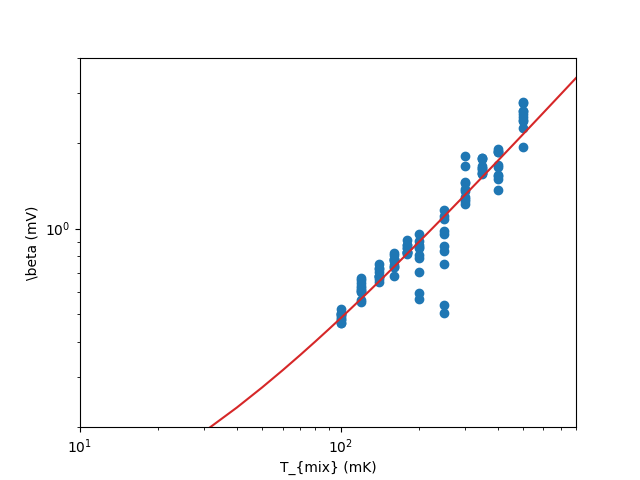

\alpha_{23}=0.0415
T(mK)=0.00415*width(mV) + 0.0685


In [19]:
fig, ax = plt.subplots(1,1)

df = pd.read_csv(os.path.join(analysis_dir,'lever-arm_peak3_dataset_1.csv'))

ax.scatter(df['Tmc'], df['beta'], c='C0', marker='o')
ff = df.loc[(df['Tmc'] > 100.0) & (df['Tmc'] < 500.0)]

popt = np.polyfit(ff['Tmc'], ff['beta'], deg=1)
tnew = np.linspace(10,800,80)
ax.plot(tnew, dt.line(tnew, *popt), c='C3')

ax.set_xlim(10, 800)
ax.set_ylim(0.2, 4.0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'\beta (mV)')
ax.set_xlabel(r'T_{mix} (mK)')

print(r'\alpha_{{23}}={0:.4f}'.format(2*K_B/popt[0]))
print('T(mK)={0:.3g}*width(mV) + {1:.3g}'.format(*popt))

### open dot

<IPython.core.display.Javascript object>


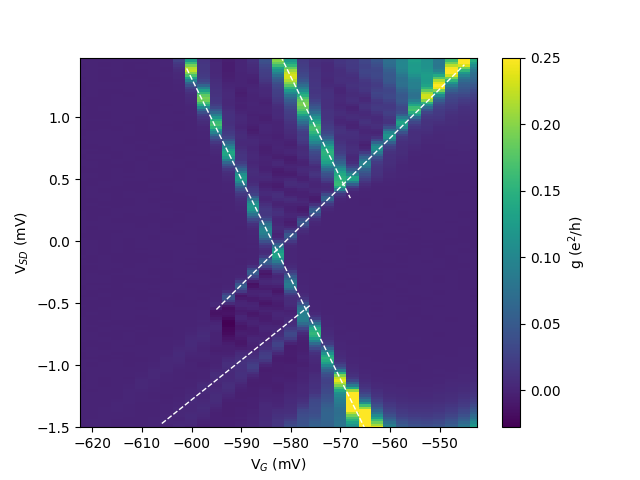

alpha_{23} = 0.02652 meV/mV
V_{bias} offset = -72.0 uV
dE = 503.1 ueV


In [20]:
dat = 1513
xmult = [0.01, 0.5] # bias mV, gate 10 mV

fig, ax = plt.subplots(1,1)

swp = dt.open_hdf5(dat, path=data_dir) # load sweep
gate = swp['y_array'][:]*xmult[1]
bias = swp['x_array'][:]*xmult[0]
cond = swp['g_dot2d'][:].transpose()
x, y, z = dt.get_subset((gate, bias, cond), [-622,-539,-1.5,1.5])

xx, yy = dt.xy_to_meshgrid(x, y)
cax = ax.pcolormesh(xx, yy, z, vmax=0.25)
cb = fig.colorbar(cax)
cb.set_label('g (e$^2$/h)')

ax.set_xlabel('V$_{G}$ (mV)')
ax.set_ylabel('V$_{SD}$ (mV)')
ax.set_xlim(x[0],x[-1])
ax.set_ylim(y[0],y[-1])

xypeaks = []
for i in range(z.shape[1]):
    ipeak = peakutils.indexes(z[:,i], thres=0.2)
    for j in ipeak:
        xypeaks.append([x[i], y[j]])
xypeaks = np.array(xypeaks)

# plot guess at GS drain line
gate = np.linspace(-595,-545, 5000)
bias = dt.line(gate, 0.039,22.65)
# check if points are on line
mask = [dt.dist_2_line(gate, bias, p, 0.05) for p in xypeaks]
drain_gs = np.polyfit(xypeaks[mask,0], xypeaks[mask,1], deg=1)
ax.plot(gate, dt.line(gate, *drain_gs), c='w', lw=1, ls='--')

# plot guess at GS source line
gate = np.linspace(-601,-564, 5000)
bias = dt.line(gate, -0.079,-46.12)
# check if points are on line
mask = [dt.dist_2_line(gate, bias, p, 0.09) for p in xypeaks]
source_gs = np.polyfit(xypeaks[mask,0], xypeaks[mask,1], deg=1)
ax.plot(gate, dt.line(gate, *source_gs), c='w', lw=1, ls='--')

# plot guess at ES source line
gate = np.linspace(-584,-568, 5000)
bias = dt.line(gate, -0.079,-44.5)
# check if points are on line
mask = [dt.dist_2_line(gate, bias, p, 0.06) for p in xypeaks]
source_es = np.polyfit(xypeaks[mask,0], xypeaks[mask,1], deg=1)
ax.plot(gate, dt.line(gate, *source_es), c='w', lw=1, ls='--')

# plot guess at ES drain line
gate = np.linspace(-606,-576, 5000)
bias = dt.line(gate, 0.035,19.7)
# check if points are on line
mask = [dt.dist_2_line(gate, bias, p, 0.1) for p in xypeaks]
drain_es = np.polyfit(xypeaks[mask,0], xypeaks[mask,1], deg=1)
ax.plot(gate, dt.line(gate, *drain_es), c='w', lw=1, ls='--')

# use these to calculate the lever arm for gate 10
alpha = 1/np.abs(1/drain_gs[0]-1/source_gs[0])
voffset = 1000*dt.y_intersection(source_gs, drain_gs)
est = 500*(np.abs(dt.y_intersection(source_es, drain_gs))+np.abs(dt.y_intersection(source_gs, drain_es)))

print('alpha_{{23}} = {0:.4g} meV/mV'.format(alpha))
print('V_{{bias}} offset = {0:.1f} uV'.format(voffset))
print('dE = {0:.1f} ueV'.format(est))